In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random

from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split

In [3]:
pd.options.display.float_format = '{:.4f}'.format
data = pd.read_csv(os.getcwd()+'\\for_modeling.csv')

In [4]:
y = data.SCALE
x = data.drop('SCALE', axis=1)

In [5]:
random_state = 5

trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.25, random_state = random_state)

In [6]:
kfold = StratifiedKFold(n_splits = 5)

classifiers = []
# classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, trainX, trainY, scoring = 'accuracy', cv = kfold, n_jobs = -1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","RandomForest","AdaBoost",
"GradientBoosting"]})

In [7]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.9623,0.0059,DecisionTree
1,0.9361,0.0231,RandomForest
2,0.9624,0.0186,AdaBoost
3,0.9756,0.0111,GradientBoosting


C:\Users\moon\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


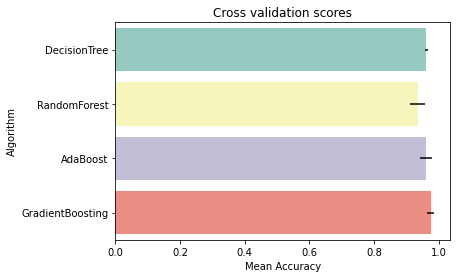

In [8]:
g = sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient='h', xerr=cv_std)
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

In [9]:
# Decision Tree Classifier

DTC = DecisionTreeClassifier()
dtc_param_distribs = {'criterion':['gini','entropy'],
                      'min_samples_leaf':randint(low=2, high=64),
                      'min_samples_split':randint(2,64),
                      'max_depth':randint(1,10)}
rsdtc = RandomizedSearchCV(DTC, param_distributions = dtc_param_distribs, cv = kfold, scoring='roc_auc', n_iter=30)

rsdtc.fit(trainX, trainY)
dtc_best = rsdtc.best_estimator_
rsdtc.best_score_

C:\Users\moon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.975844066971939

In [10]:
# Adaboost Classifier

DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state = random_state)
ada_param_distribs = {'base_estimator__criterion':['gini','entropy'],
                 'base_estimator__splitter':['best','random'],
                 'algorithm':['SAMME','SAMME.R'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}
rsadaDTC = RandomizedSearchCV(adaDTC, param_distributions = ada_param_distribs, cv = kfold, scoring='roc_auc', n_iter = 30)

rsadaDTC.fit(trainX, trainY)
ada_best = rsadaDTC.best_estimator_
rsadaDTC.best_score_

0.9823972314181482

In [11]:
# Random Forest Classifier

RFC = RandomForestClassifier()

rf_param_distribs = {'max_features':randint(1, 16),
                'min_samples_split':randint(2, 16),
                'min_samples_leaf':randint(2, 64),
                'n_estimators':randint(20, 256)}
rsRFC = RandomizedSearchCV(RFC, param_distributions = rf_param_distribs, cv = kfold, scoring='roc_auc', n_iter = 30)

rsRFC.fit(trainX, trainY)
RFC_best = rsRFC.best_estimator_
rsRFC.best_score_

C:\Users\moon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9725645584501663

In [12]:
GBC = GradientBoostingClassifier()
gb_param_distribs={'n_estimators':randint(10,200),
              'learning_rate':[0.01, 0.025, 0.05, 0.1],
              'max_depth':randint(2,15),
              'min_samples_leaf':randint(5,15),
              'max_features':randint(2,15)}

rsGBC = RandomizedSearchCV(GBC,param_distributions=gb_param_distribs, cv=kfold, scoring='roc_auc', n_iter = 30)

rsGBC.fit(trainX, trainY)
GBC_best = rsGBC.best_estimator_

rsGBC.best_score_

0.9831328662108013

In [13]:
XGB = xgb.XGBClassifier()

XGB_param_distribs = {'max_depth': list(range(2,10)), 
                  'subsample': np.linspace(0.4, 1, 7)}

rsXGB = RandomizedSearchCV(estimator = XGB,
                                param_distributions = XGB_param_distribs,
                                n_iter = 30,
                                scoring='roc_auc',  
                                cv = kfold, 
                                refit=True, 
                                return_train_score = True)

rsXGB.fit(trainX, trainY)
XGB_best = rsXGB.best_estimator_

rsXGB.best_score_

0.9839976940479085

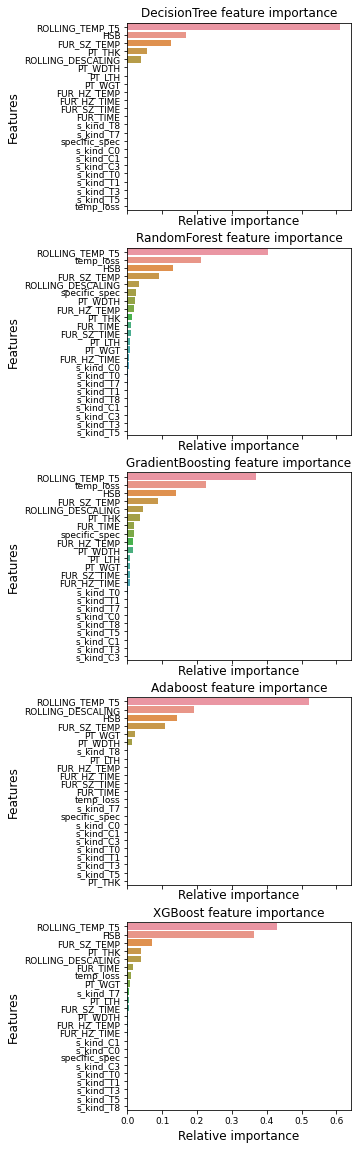

In [14]:
# 주요 변수 산출
nrows = 5
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (4,20))

names_classifiers = [('DecisionTree', dtc_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best),('Adaboost',ada_best),('XGBoost',XGB_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        if nclassifier >= 5:
            break
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=trainX.columns[indices][:40], x = classifier.feature_importances_[indices][:40], orient = 'h', ax = axes[row])
        
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

In [73]:
df_importance = pd.DataFrame()
df_importance['Feature'] = trainX.columns

for idx, v in enumerate(names_classifiers):
    df_importance[names_classifiers[idx][0]] = names_classifiers[idx][1].feature_importances_

def select_classifier(df, feature):
    df = df.sort_values(by=feature, ascending=False).reset_index(drop=True)[['Feature',feature]]
    sum_ = df.iloc[:,1].sum()
    df = df [df.iloc[:,1] >= 0.05]
    df=df.append({'Feature' : 'etc' , feature : abs(1.0 - sum_)} , ignore_index=True)
    return df

C:\Users\moon\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """


([<matplotlib.patches.Wedge at 0x1ea8103af88>,
 [Text(-0.372514856374042, 1.0350037109984809, 'ROLLING_TEMP_T5'),
  Text(-0.3792025029048639, -1.0325722549975314, 'HSB'),
  Text(0.5938903966769249, -0.925901828886262, 'FUR_SZ_TEMP'),
  Text(1.0014944578909384, -0.4549822532953735, 'PT_THK'),
  Text(1.0666790263377575, -0.2686928632679587, 'etc')],
 [Text(-0.20318992165856836, 0.5645474787264441, '61.0%'),
  Text(-0.20683772885719848, -0.5632212299986533, '16.8%'),
  Text(0.32394021636923176, -0.5050373612106883, '12.6%'),
  Text(0.5462697043041481, -0.2481721381611128, '5.7%'),
  Text(0.5818249234569585, -0.14655974360070473, '0.0%')])

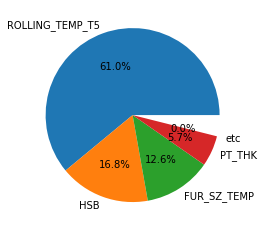

In [68]:
df_dt = select_classifier(df_importance, 'DecisionTree')

df_dt

plt.pie(df_dt.DecisionTree, labels = df_dt.Feature, autopct='%.1f%%')

<AxesSubplot:>

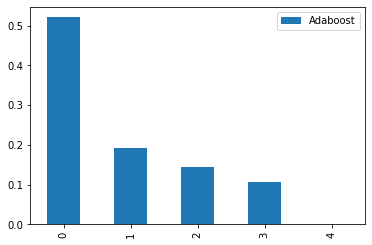

In [77]:
select_classifier(df_importance, 'Adaboost').plot(kind='bar')

In [74]:
select_classifier(df_importance, 'GradientBoosting')

,Feature,GradientBoosting
0,ROLLING_TEMP_T5,0.3685
1,temp_loss,0.2264
2,HSB,0.1396
3,FUR_SZ_TEMP,0.0890
4,etc,0.0000


In [49]:
select_classifier(df_importance, 'XGBoost')

,Feature,XGBoost
0,ROLLING_TEMP_T5,0.4288
1,HSB,0.3628
2,FUR_SZ_TEMP,0.0711


In [ ]:
select_classifier(df_importance, 'Adaboost')

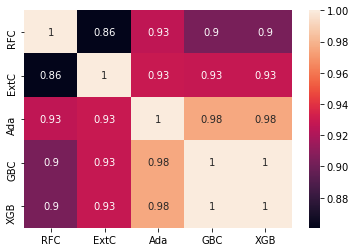

In [24]:
test_RFC = pd.Series(RFC_best.predict(testX), name="RFC")
test_DTC = pd.Series(dtc_best.predict(testX), name="ExtC")
test_AdaC = pd.Series(ada_best.predict(testX), name="Ada")
test_GBC = pd.Series(GBC_best.predict(testX), name="GBC")
test_XGB = pd.Series(XGB_best.predict(testX), name="XGB")

ensemble_results = pd.concat([test_RFC,test_DTC,test_AdaC,test_GBC, test_XGB],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [25]:
votingC = VotingClassifier(estimators=[('dtc',dtc_best),('rfc', RFC_best),('adac',ada_best),('gbc',GBC_best),('xgb',XGB_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(trainX, trainY)
y_hat = votingC.predict(testX)

print(confusion_matrix(testY, y_hat))
print('accuracy: ', accuracy_score(testY, y_hat))
print('precision: ', precision_score(testY, y_hat))
print('recall: ', recall_score(testY, y_hat))
print('f1_score: ',f1_score(testY, y_hat))

[[115   0]
 [  1  62]]
accuracy:  0.9943820224719101
precision:  1.0
recall:  0.9841269841269841
f1_score:  0.9919999999999999
